In [1]:
import os
import mokapot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
sys.path
import data_loader


The purpose of this function is to clean up the original 'before' data so that we are not counting decoys or duplicate scans.
Mokapot needs the decoys, so they are only removed from the 'before' data.

In [2]:
def filter_data(df, prob_column='PeptideProphet Probability'):
     #drop decoy
    df = df[df["decoy"]==False]
    #sort by qvalue
    df = df.sort_values(prob_column)
    #drop duplicate scans
    df = df.drop_duplicates(subset=["scan"], keep="first") #keep highest scoring
    return df

MsFragger does not have a q value, instead it has a "PeptideProphet Probability". Their scoring of this works backwards from all the other tools. A number closer to 1 is better than a number closer to 0. In order to compare the tools all together, we convert this score to the same scale as all the rest of our data. This function accomplishes that. 

In [3]:
#chaning the probability column to be the same scale as all the other tools
def set_probablility(row):
    new_prob = 1 - row['PeptideProphet Probability']
    return new_prob

MokaPot needs a column that notates where a scan was decoy or not. The "make_target_col_msfragger" function generates that column.

In [4]:
def make_target_col_msfragger(row):
    if row["Protein"].startswith("rev"):
        return False
    else:
        return True

MsFragger combines the scan number with the file name.
In order to compares MsFragger to the rest of the tools we 
use the "extractScanNum" function to seperate the scan number.

In [5]:
#pulling only scan numbers out
def extractScanNum(row):
    string = row
    spot = string.find('.')
    new_st = string[spot + 1:]
    spot = new_st.find('.')
    final_st = new_st[:spot]
    
    if final_st[0] == "0":
        final_st = final_st[1:]
    return final_st

This gives us back the "before" dataset. We will clean the data by dropping duplicates and decoys. The purpose of this is to be able to count how many scans we originally have at or under a specific cutoff. 

In [6]:
def get_PreMokaPot_data(file):
    msf_df = data_loader.clean_msfragger(file)
    msf_df = filter_data(msf_df)
    
    #Changing the probabilities to the same scale all the other tools use 
    msf_df["Updated_probability"] = msf_df.apply(set_probablility, 1)
    return msf_df

This is where we will get the data, and format it for Mokapot. 
We have to make the target column to represent decoys, we rename the scan column to match the rest of the data when we make the megascript, and change the probabililty column to the same scale as the output from the rest of the tools. We also drop any duplicate scan numbers before we feed the data into MokaPot.

In [7]:
def get_data_for_MokaPot(file):
    msf_df = data_loader.clean_msfragger(file)
    
    msf_df["target_column"] = msf_df.apply(make_target_col_msfragger, axis = 1)
    
     #Extracting scan number from file number
    msf_df['scan'] =msf_df['scan'].apply(extractScanNum) 
    
    msf_df = msf_df.rename(columns = {"scan": "ScanNr"})
    
    #Changing the probabilities to the same scale all the other tools use. Dropping the old probability column
    msf_df["Updated_probability"] = msf_df.apply(set_probablility, 1)
    
    #sort by q value and drop duplicate scans
    msf_df = msf_df.sort_values("Updated_probability")
    msf_df = msf_df.drop_duplicates(subset=["ScanNr"], keep="first") #keep highest scoring
    
    return msf_df
    
    

This is code that was taken directly from the MokaPot program. It formats the data for the graphs. The purpose of the graphs is to compare the preMokaPot data to the postMokaPot data and compare if we are getting more scans at or below a certain cutoff after running data through MokaPot.

In [8]:
def plot_qvalues(df, level="psms", threshold=0.01, ax=None, **kwargs):
    qvals = df["probability"]

    ax = plot_qvalues(qvals, threshold=threshold, ax=ax, **kwargs)
    ax.set_xlabel("q-value")
    ax.set_ylabel(f"Accepted {self._level_labs[level]}")

    return ax

In [9]:
def plot_qvalues(qvalues, threshold=0.01, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # Calculate cumulative targets at each q-value
    qvals = pd.Series(qvalues, name="qvalue")
    qvals = qvals.sort_values(ascending=True).to_frame()
    qvals["target"] = 1
    qvals["num"] = qvals["target"].cumsum()
    qvals = qvals.groupby(["qvalue"]).max().reset_index()
    qvals = qvals[["qvalue", "num"]]

    zero = pd.DataFrame({"qvalue": qvals["qvalue"][0], "num": 0}, index=[-1])
    qvals = pd.concat([zero, qvals], sort=True).reset_index(drop=True)

    xmargin = threshold * 0.05
    ymax = qvals.num[qvals["qvalue"] <= (threshold + xmargin)].max()
    ymargin = ymax * 0.05

    # Set margins
    curr_ylims = ax.get_ylim()
    if curr_ylims[1] < ymax + ymargin:
        ax.set_ylim(0 - ymargin, ymax + ymargin)

    ax.set_xlim(0 - xmargin, threshold + xmargin)
    ax.set_xlabel("q-value")
    ax.set_ylabel(f"Discoveries")

    ax.step(qvals["qvalue"].values, qvals.num.values, where="post", **kwargs)

    return ax

In [10]:
#Reading all the files into a list here
file_names = ["2ng_rep1", "2ng_rep2", "2ng_rep3", "2ng_rep4", "2ng_rep5", "2ng_rep6",
             "0.2ng_rep1", "0.2ng_rep2", "0.2ng_rep3", "0.2ng_rep4", "0.2ng_rep5", "0.2ng_rep6"]


This is where we run each input file through MokaPot. Each file we read in is analyzed and the results are saved in a seperate output file. 

MokaPot requires feature columns that it uses to give each scan a new q value score. The columns from MsFragger that we have chosen to use as features are: 'Peptide Length', 'Retention', 'Delta Mass', 'Expectation', 'Hyperscore', 'Nextscore', 'Number of Enzymatic Termini', 'Number of Missed Cleavages', 'Intensity'. 'Charge' is also used as a one hot encoding. 

In [11]:
for file in file_names:
    msf_cleaned_df = get_PreMokaPot_data(file)
    msf_df = get_data_for_MokaPot(file)
    
    charge_feat = pd.get_dummies(msf_df["Charge"], prefix="Charge")
    msf_df = pd.concat([msf_df, charge_feat], axis=1)
    msf_for_MP = mokapot.dataset.LinearPsmDataset(msf_df, target_column = "target_column", spectrum_columns = "ScanNr", 
                                                  peptide_column = "peptide", protein_column=None, 
                                                  group_column=None, feature_columns= (list(charge_feat.columns) +  ['Peptide Length', 'Retention', 'Delta Mass', 
                                                  'Expectation', 'Hyperscore', 'Nextscore', 'Number of Enzymatic Termini', 
                                                  'Number of Missed Cleavages', 'Intensity']), copy_data=True)
    
    #charge, length, retention, delta mass, expectation, hyperscore, nextScore, termini, missed cleavage, intensity,

    results, models = mokapot.brew(msf_for_MP)

    results_df = results.psms
    results_df.to_csv("MokaPot_Output/MsFragger/msf_" + file + ".csv")

Here we graph the results for pre and post MokaPot. We are plotting MsFragger's Peptide Prophet Probability values against the q values that MokaPot improved on.

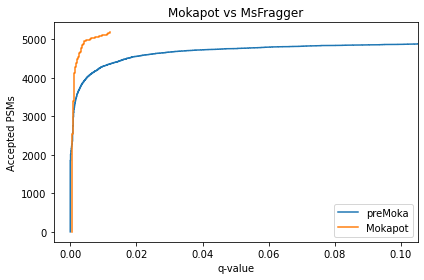

In [12]:
plot_qvalues(msf_cleaned_df["Updated_probability"], label="Pre-mokapot")
plt.title("Mokapot vs MsFragger")
results.plot_qvalues(label="mokapot")
plt.legend(["preMoka", "Mokapot"])

plt.tight_layout()

plt.show()

In [13]:
print("The number of PSMs found at or above 0.01: ") 
      
print("\t" + "MsFragger: " + str(len(msf_cleaned_df[msf_cleaned_df['PeptideProphet Probability'] >= 0.99])))

print("\t" + "MsFragger: " + str(len(msf_cleaned_df[msf_cleaned_df['Updated_probability'] <= 0.01])))

print("\t""MsFragger and MokaPot: " + str(len(results.psms[results.psms['mokapot q-value'] <= 0.01])))

The number of PSMs found at or above 0.01: 
	MsFragger: 4304
	MsFragger: 4299
	MsFragger and MokaPot: 5110


* Need to fix the temp peptide column (what is that?)